training score : 0.995 (multinomial)
training score : 0.976 (ovr)


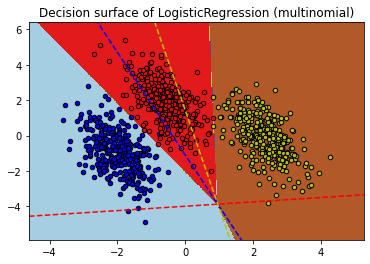

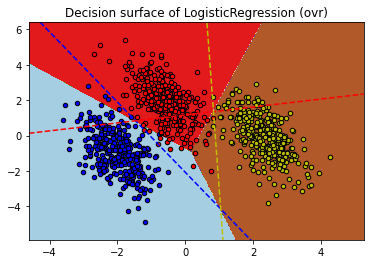

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for multi_class in ("multinomial", "ovr"):
    clf = LogisticRegression(
        solver="sag", max_iter=100, random_state=42, multi_class=multi_class
    ).fit(X, y)

    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

    # create a mesh to plot in
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis("tight")

    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
        )

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_
    
    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

        plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

plt.show()

X는 입력, y는 출력<br>
각각 클래스 1, 2, 3에 따라 데이터 분할

In [397]:
print('class 0 데이터 수: ', X[np.where(y == 0)].shape)
print('class 1 데이터 수: ', X[np.where(y == 1)].shape)
print('class 2 데이터 수: ', X[np.where(y == 2)].shape)

class 0 데이터 수:  (334, 2)
class 1 데이터 수:  (333, 2)
class 2 데이터 수:  (333, 2)


---

## One-vs-Rest(ovr) Logistic Regression
위에서 결정 경계의 방정식은 두 클래스의 데이터를 이진 분류 했을 때의 방정식으로 볼 수 있음<br>
ex) 0과 (1, 2)의 결정경계 방정식, 1과 (2, 3)의 결정경계 방정식, 2와 (0, 1)의 결정경계 방정식

### 로지스틱 손실함수
이진 분류일 때<br>
$\mathbf{z} = \mathbf{w}\mathbf{X} + \mathbf{b}$<br>
$\mathbf{a} = \sigma(\mathbf{z})$<br>
<br>
$E_n(\mathbf{w}) = -\{y_n \ln a_n + (1 - y_n) \ln(1 - a_n) \}$에서 그레디언트를 구해주면<br>
<br>
$\begin{aligned} \nabla_w E_{n}(\mathbf{w}) &=\frac{\partial E_{n}(\mathbf{w})}{\partial a_{n}} \frac{\partial a_{n}}{\partial z_{n}} \nabla_w z_{n} \\ &=\left\{\frac{1-y_{n}}{1-a_{n}}-\frac{y_{n}}{a_{n}}\right\} a_{n}\left(1-a_{n}\right) x_{n} \\ &=\left(a_{n}-y_{n}\right) x_{n} \\ &= -\left(y_{n} - a_{n}\right) x_{n} \end{aligned}$<br>
<br>
마찬가지로 절편도 미분해주면<br>
$\begin{aligned} \nabla_b E_{n}(\mathbf{w}) &=\frac{\partial E_{n}(\mathbf{w})}{\partial a_{n}} \frac{\partial a_{n}}{\partial z_{n}} \nabla_b z_{n} \\ &=-\left(y_{n} - a_{n}\right) \end{aligned}$

### 결정경계 방정식
$w_1 x_1 + w_2 x_2 + b = 0 \Leftrightarrow \mathbf{w}^T \mathbf{X} + \mathbf{b} = 0$ 형태의 그래프를 최적화 시켜주고<br>
경사하강법을 통해 수렴하는 기울기와 절편($\mathbf{w}, b$)을 구해주기

In [3]:
# 시그모이드 함수
def sigmoid(X):
    # X에서 매우 작은 값을 -100으로 맞춰 줌 (지수함수 계산 시 한없이 커지는 값이 안나오도록 조정)
    X = np.clip(X, -100, None)
    return 1 / (1 + np.exp(-X))

In [4]:
from copy import deepcopy

# c클래스를 분류
def get_equation_in_ovr(c):
    # c클래스의 레이블 값을 1, 나머지 레이블 값을 0
    yy = deepcopy(y)
    
    yy[np.where(y != c)] = 0
    yy[np.where(y == c)] = 1
    
    colors = "br"
    for i, color in zip([1, 0], colors):
        idx = np.where(yy == i)
        plt.title('blue: label == class / red: label != class')
        plt.scatter(
            X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
        )
    
    w = np.ones(X.shape[1])
    b = 1
    
    # 학습률
    lr = 0.02
    loss_history = []

    # epoch는 200으로 고정
    for _ in range(200):
        loss = 0
        
        # 1000개의 데이터
        for x_i, y_i in zip(X, yy):
        # for i in range(1000):
            # z = wX + b
            z = w.dot(x_i) + b
            a = sigmoid(z)

            # -(y - a)
            loss_grad_common = -(y_i - a)
            
            # 가중치, 절편의 그레디언트
            # w_grad = -(y - a)x
            # b_grad = -(y - a)
            w_grad = loss_grad_common * x_i
            b_grad = loss_grad_common
            
            w -= w_grad * lr
            b -= b_grad * lr
            
            # 로그함수 계산 안정성 확보(log0 방지)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss += -(y_i*np.log(a) + (1 - y_i)*np.log(1 - a))
        loss_history.append(loss / len(y))
        
    return w, b, loss_history

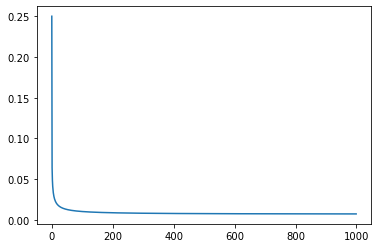

In [433]:
# epoch를 1000으로할 때 손실함수 확인
_, _, loss_history = get_equation_in_ovr(0)

%matplotlib inline

plt.plot(loss_history)
plt.show()

epoch를 1000일 때와 200정도 일 때 손실값이 비슷한 것을 확인 할 수 있음<br>
epoch는 200으로 고정

In [5]:
# 방정식 정보 출력
def print_equation_info(W, b):
    print('W[0]X[0] + W[1]X[0] + b = 0')
    print('X[0]의 가중치:', W[0])
    print('X[1]의 가중치:', W[1])
    print('절편:', b)
    print()
    return

In [6]:
# 구해진 가중치와 절편을 이용해 방정식 출력
def get_equation(W, b):
    slope = -W[0] / W[1]
    intercept = -b / W[1]
    
    i = f'{intercept:.2f}'
    if intercept > 0:
        i = f'+{intercept:.2f}'
    print('X[1]에 관해 방정식 정리')
    print('기울기:', slope)
    print('절편:', intercept)
    print(f"X[1] = {slope:.2f}X[0] {i}")
    return slope, intercept

In [7]:
# ploting the equation
def plot_equation(m, b):
    x_nums = [j for j in range(-5, 5)]
    y_nums = [m * k + b for k in x_nums]
    
    plt.axis([-5, 4, -8, 6])
    plt.plot(x_nums, y_nums)
    plt.grid()
    plt.show()
    
    return

$w_0x_0 + w_1x_1 + b = 0$의 꼴을 $x_1$에 관하여 정리하면<br>
$\displaystyle x_1 = -\frac{w_0}{w_1}x_0 - \frac{b}{w_1}$로 정리가능<br>
따라서 기울기(slope): $\displaystyle -\frac{w_0}{w_1}$, 절편(intercept): $\displaystyle -\frac{b}{w_1}$

W[0]X[0] + W[1]X[0] + b = 0
X[0]의 가중치: -7.218750755223795
X[1]의 가중치: -3.4655555845119568
절편: -7.536277150201477

X[1]에 관해 방정식 정리
기울기: -2.0829995592872272
절편: -2.1746230774315474
X[1] = -2.08X[0] -2.17


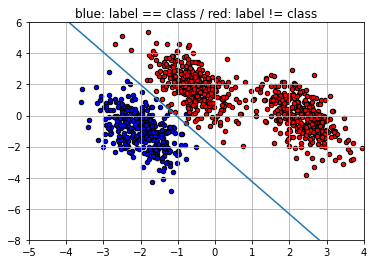

In [451]:
# class 0만 따로 분리
W, b, loss_history = get_equation_in_ovr(0)
eq0_w0, eq0_w1, eq0_b = W[0], W[1], b
print_equation_info(W, b)

# X[1]에 관해 방정식 정리한 후 기울기와 절편
eq0_slope, eq0_intercept = get_equation(W, b)
# 방정식 그리기
plot_equation(eq0_slope, eq0_intercept)

W[0]X[0] + W[1]X[0] + b = 0
X[0]의 가중치: -0.4594649898584226
X[1]의 가중치: 1.7079442323766612
절편: -1.9185375165238916

X[1]에 관해 방정식 정리
기울기: 0.2690163889128053
절편: 1.1233022016498646
X[1] = 0.27X[0] +1.12


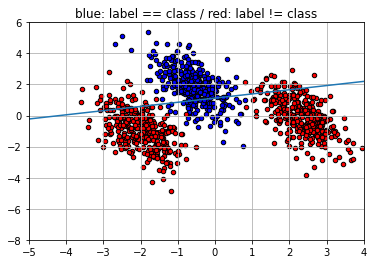

In [452]:
# class 1만 따로 분리
W, b, loss_history = get_equation_in_ovr(1)
eq1_w0, eq1_w1, eq1_b = W[0], W[1], b
print_equation_info(W, b)

# X[1]에 관해 방정식 정리한 후 기울기와 절편
eq1_slope, eq1_intercept = get_equation(W, b)
# 방정식 그리기
plot_equation(eq1_slope, eq1_intercept)

W[0]X[0] + W[1]X[0] + b = 0
X[0]의 가중치: 7.992761082303547
X[1]의 가중치: 0.41496310931127184
절편: -6.904413116504284

X[1]에 관해 방정식 정리
기울기: -19.26137746453992
절편: 16.638619100294893
X[1] = -19.26X[0] +16.64


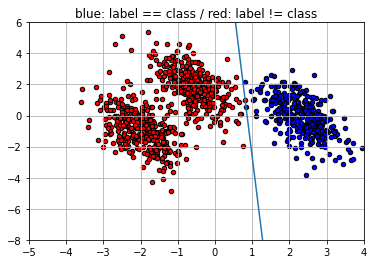

In [453]:
# class 2만 따로 분리
W, b, loss_history = get_equation_in_ovr(2)
eq2_w0, eq2_w1, eq2_b = W[0], W[1], b
print_equation_info(W, b)

# X[1]에 관해 방정식 정리한 후 기울기와 절편
eq2_slope, eq2_intercept = get_equation(W, b)
# 방정식 그리기
plot_equation(eq2_slope, eq2_intercept)

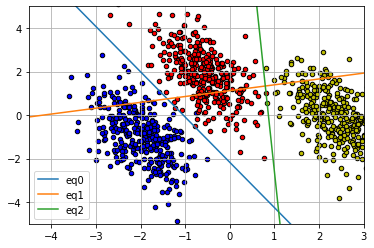

In [494]:
x_num = [i for i in range(-5, 6)]
y0 = [eq0_slope * j + eq0_intercept for j in x_num]
y1 = [eq1_slope * j + eq1_intercept for j in x_num]
y2 = [eq2_slope * j + eq2_intercept for j in x_num]

colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
    )
        
plt.plot(x_num, y0)
plt.plot(x_num, y1)
plt.plot(x_num, y2)
plt.axis([-4.5, 3.0, -5, 5])
plt.grid()
plt.legend(['eq0', 'eq1', 'eq2'])
plt.show()

### (참고) 사이킷런 분류기를 사용했을 때와 비교

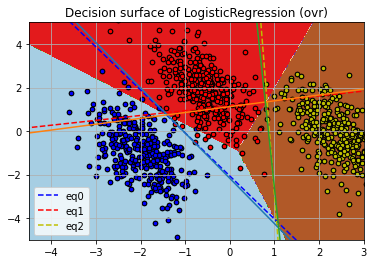

In [524]:
clf = LogisticRegression(
    solver="sag", max_iter=100, random_state=42, multi_class='ovr'
).fit(X, y)

# create a mesh to plot in
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
plt.axis("tight")

# Plot also the training points
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
    )
    
    
# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_

def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color)

for i, color in zip(clf.classes_, colors):
    plot_hyperplane(i, color)



x_num = [i for i in range(-5, 6)]
y0 = [eq0_slope * j + eq0_intercept for j in x_num]
y1 = [eq1_slope * j + eq1_intercept for j in x_num]
y2 = [eq2_slope * j + eq2_intercept for j in x_num]

colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
    )
        
plt.plot(x_num, y0)
plt.plot(x_num, y1)
plt.plot(x_num, y2)
plt.axis([-4.5, 3.0, -5, 5])
plt.grid()
plt.legend(['eq0', 'eq1', 'eq2'])
plt.show()

In [527]:
# 위 그림에서 그린 점선은 다음과 같이 clf.coef_, clf.intercept_로 가중치와 절편을 구할 수 있음
for idx in range(3):
    _1, _2 = get_equation(clf.coef_[idx, :], clf.intercept_[idx])
    print()

X[1]에 관해 방정식 정리
기울기: -1.9796548534599443
절편: -2.066644720448883
X[1] = -1.98X[0] -2.07

X[1]에 관해 방정식 정리
기울기: 0.22433940267718458
절편: 1.166893565585324
X[1] = 0.22X[0] +1.17

X[1]에 관해 방정식 정리
기울기: -25.934241118895198
절편: 23.007948346933624
X[1] = -25.93X[0] +23.01



참고로 직접 모델을 썼을 때 위와 같은 3개의 그래프를 얻을 수 있고,<br>
우리가 직접 구한 직선과 매우 흡사함을 볼 수 있음

## 3개의 방정식을 구했는데 어떻게 결정경계를 나눠야할까?

우선 위에서 3개의 방정식으로 인해 나누어진 평면은 총 3가지로 나눌 수 있다.<br>
1. 3개의 방정식에 의해 무한한 평면이 만들어진 경우
   - 위 그림에서는 6 ~ 8시, 12시, 3 ~ 5시 평면<br>
   - 직관적으로 이 영역에 있는 대부분의 점들은 **같은 클래스에 있는 점들 끼리분류**가 된 것을 알 수 잇음<br><br>
2. 2개의 방정식에 의해 무한한 평면이 만들어진 경우
   - 위 그림에서는 11시, 1시, 6시(아주 작은 구역)<br>
   - 위 그림에서는 이 영역에 있는 점들은 한 가지 클래스에 해당하는 점들만 있지만<br>
     **직관적으로 생각해보면 대부분 두 가지의 클래스의 점들로 공존**할 수 있음<br>
   - 따라서 이 영역에서 두 클래스를 분류할 수 있는 **기준선**이 필요<br><br>
3. 3개의 방정식에 의해 유한한 평면(내부 삼각형)이 만들어진 경우
   - 위 그림에서 정가운데 삼각형 영역<br>
   - **직관적으로 세 가지 클래스의 점들이 공존할 수 있음**<br>
   - 마찬가지로 삼각형 내부에 클래스를 분류시킬 **기준선**이 필요<br><br>

---

### 가설 1

#### "만약 임의의 한 점에서 1에서 구한 3가지 평면(3가지 방정식)에 대해 거리를 구했을 때, A클래스 평면에 더 근접해 있으면 A클래스로 가정"

2, 3에서 말한대로 기준선에 의해 결정 평면을 나누어야 함<br>
<br>
**두 가지 직선으로 인해 만들어진 교점에서의 각을 이등분하는 직선(내부 삼각형 중심을 향하는 직선)** 이 기준선이 될 것이다.<br>
공교롭게도 삼각형 내부에서도 이 직선이 기준선이 되는 것은 분명 유효할 것이다(이등분되는 두 각은 서로 맞꼭지각이기 때문).<br>
그렇게 삼각형 내부에 3개의 직선(3개의 교점에서 만들어지는 직선)이 존재할 것이다.<br>

---

### 삼각형 내부에서의 중심

삼각형 내부에 3개의 직선이 존재하게 될 것을 확인<br>
그렇다면 **3개의 직선이 서로 매우 근접해 있을 때** 어떻게 결정 경계를 나눠줄 것인가?<br>
<br>
공교롭게도 3개의 직선은 **한 점에서 만난다는 것은 자명**하다.<br>
위의 가설에 의하면 3개의 직선이 만나는 점은 **삼각형의 내심**이기 때문이다<br>
따라서 **내심으로부터 삼각형을 구성하는 각 교점을 지나는 직선이 곧 결정 경계**를 나타내는 방정식이 된다<br>
<br>
3개의 방정식을 구하고나서 각각의 방정식이 한 점을 지나는지 확인해보면서 검산해보자

---

### 방정식 구하기

#### 교점 구하기
연립 방정식을 통해 해를 구하기
$b = WX \Leftrightarrow X = W^{-1}b$

#### 결정 경계 방정식

삼각형의 한 점에서 각을 이등분 하는 직선이 결정경계의 방정식<br>
<br>
두 직선의 기울기를 각각 $m_1, m_2$라고 하고, 발생하는 각의 크기를 $\theta$라고 할 때($\tan \alpha > \tan \beta, m2 > m1$)<br>
$ \displaystyle \tan\theta = \frac{\tan \alpha - \tan \beta}{1 + \tan \alpha \tan \beta} = \frac{m_2 - m_1}{1 + m_1m_2} \Leftrightarrow \theta = \tan^{-1}\left(\frac{m_2 - m_1}{1 + m_1m_2} \right)$<br>
<br>
구하려고 하는 직선의 기울기를 $m$이라고 하면<br>
$ \displaystyle \tan\frac{\theta}{2} = \frac{\tan \gamma - \tan \beta}{1 + \tan \gamma \tan \beta} = \frac{m - m_1}{1 + m_1m} = A$<br>
<br>
이에 따라 $m - m_1 = A + Am_1m$이 성립하고<br>
구하려고 하는 직선의 기울기는 다음과 같다<br>
$ \displaystyle m = \frac{m_1 + A}{1 - Am_1}$

In [8]:
# 교점 구하기
def get_cross_point(w11, w12, b1, w21, w22, b2):
    W = np.array([[w11, w12],
                  [w21, w22]])
    b = np.array([-b1, -b2])
    
    return np.linalg.inv(W)@b.T

In [481]:
# eq0과 eq1의 교점(왼쪽 교점)
x0_01, x1_01 = get_cross_point(eq0_w0, eq0_w1, eq0_b, eq1_w0, eq1_w1, eq1_b)
A = (x0_01, x1_01)

# eq1과 eq2의 교점(위쪽 교점)
x0_12, x1_12 = get_cross_point(eq1_w0, eq1_w1, eq1_b, eq2_w0, eq2_w1, eq2_b)
B = (x0_12, x1_12)

# eq2과 eq0의 교점(아래쪽 교점)
x0_20, x1_20 = get_cross_point(eq2_w0, eq2_w1, eq2_b, eq0_w0, eq0_w1, eq0_b)
C = (x0_20, x1_20)

print('eq0과 eq1의 교점', A)
print('eq1과 eq2의 교점', B)
print('eq2와 eq0의 교점', C)

eq0과 eq1의 교점 (-1.4021696075680405, 0.7460955971786252)
eq1과 eq2의 교점 (0.7944190483338418, 1.3370139453161822)
eq2와 eq0의 교점 (1.0951698863240078, -4.455861467989099)


In [9]:
# 결정 경계 방정식의 기울기
def get_slope_decision_boundary(m1, m2):
    m1, m2 = min(m1, m2), max(m1, m2)
    tan_theta = (m2 - m1) / (1 + m1 * m2)
    theta = np.arctan(tan_theta)
    
    # 이등분한 각의 탄젠트 값
    A = np.tan(theta / 2)
    
    return (m1 + A) / (1 - A * m1)

In [482]:
# 왼쪽 교점에서 각을 이등분 할 때의 기울기
m1 = get_slope_decision_boundary(eq0_slope, eq1_slope)
# 위쪽 교점에서 각을 이등분 할 때의 기울기
m2 = get_slope_decision_boundary(eq1_slope, eq2_slope)
# 아래쪽 교점에서할 각을 이등분 할 때의 기울기
m3 = get_slope_decision_boundary(eq2_slope, eq0_slope)
print('왼쪽 교점에서 각을 이등분 할 때의 기울기', m1)
print('위쪽 교점에서 각을 이등분 할 때의 기울기', m2)
print('아래쪽 교점에서 각을 이등분 할 때의 기울기', m3)

왼쪽 교점에서 각을 이등분 할 때의 기울기 -0.45887462022673337
위쪽 교점에서 각을 이등분 할 때의 기울기 1.377114987456176
아래쪽 교점에서 각을 이등분 할 때의 기울기 -3.920788177763775


#### 방정식 구하기

직선의 기울기($m$)와 그 직선이 지나는 한 점($a, b$)을 알고 있으니 직선의 방정식을 구할 수 있다. 방정식은 다음과 같다<br>
$x_2 = m(x_1 - a) + b = mx_1 + (-ma + b)$

In [10]:
# 방정식 구하기
def get_answer(m, point):
    intercept = -m * point[0] + point[1]
    if intercept > 0:
        equation = f"x_2 = {m:.2f}x_1 +{intercept:.2f}"
    else:
        equation = f"x_2 = {m:.2f}x_1 {intercept:.2f}"
    return equation

In [529]:
# 1번 방정식
get_answer(m1, A)

'x_2 = -0.46x_1 +0.10'

In [530]:
# 2번 방정식
get_answer(m3, C)

'x_2 = -3.92x_1 -0.16'

In [531]:
# 3번 방정식
get_answer(m2, B)

'x_2 = 1.38x_1 +0.24'

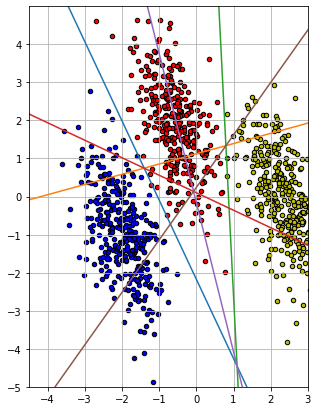

In [505]:
x_num = [i for i in range(-5, 6)]
y0 = [eq0_slope * j + eq0_intercept for j in x_num]
y1 = [eq1_slope * j + eq1_intercept for j in x_num]
y2 = [eq2_slope * j + eq2_intercept for j in x_num]

plt.figure(figsize = (5, 7))

colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
    )
        
ans1 = [-0.46 * j + 0.1 for j in x_num]
ans2 = [-3.92 * j - 0.16 for j in x_num]
ans3 = [1.38 * j + 0.24 for j in x_num]

plt.plot(x_num, y0)
plt.plot(x_num, y1)
plt.plot(x_num, y2)

plt.plot(x_num, ans1)
plt.plot(x_num, ans2)
plt.plot(x_num, ans3)

# plt.axis([-4.5, 3.0, -5, 5])
plt.xlim([-4.5, 3.0])
plt.xticks([x_tick for x_tick in range(-4, 4)])

plt.ylim([-5, 5])
plt.yticks([y_tick for y_tick in range(-5, 5)])
plt.grid()


plt.show()

위의 그래프를 보면 기존 파랑, 주황, 녹색 그래프 외에 3가지 그래프(빨강, 보라, 갈색)가 더 추가되었음(정답 그래프)<br>
이 세 개의 그래프는 삼각형의 각 꼭지점을 이등분하는 직선임을 육안으로 확인할 수 있으며<br>
**한 점(내심)을 지나는 것을 확인할 수 있음**<br>
<br>
이를 토대로 정확하게 3개의 그래프를 그렸다는 것을 확인할 수 있음<br>
<br>
1번 방정식: $x_2 = -0.46x_1 + 0.10$<br>
2번 방정식: $x_2 = -3.92x_1 - 0.16$<br>
3번 방정식: $x_2 = 1.38x_1 + 0.24$<br>

#### 가설 확인

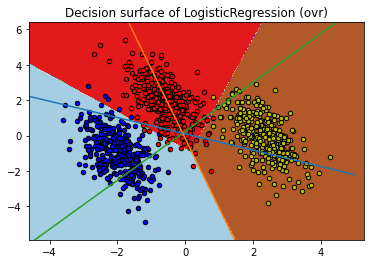

In [559]:
# 실제 결정경계와 동일한지 확인

# create a mesh to plot in
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.title("Decision surface of LogisticRegression (ovr)")
plt.axis("tight")

# Plot also the training points
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
    )
    
ans1 = [-0.46 * j + 0.1 for j in x_num]
ans2 = [-3.92 * j - 0.16 for j in x_num]
ans3 = [1.38 * j + 0.24 for j in x_num]

plt.plot(x_num, ans1)
plt.plot(x_num, ans2)
plt.plot(x_num, ans3)
plt.show()

위에서 구했던 결정경계와 비교해보면 많이 차이나는 것을 확인할 수 있음<br>
특히 삼각형의 중심이 내심이 아니라는 사실을 알 수 있음<br>
**기준선에 대한 가설이 잘못되었음**

---

### 가설 2 
#### "교점들의 평균지점이 삼각형의 중심이고, 그 중심과 각 교점을 잇는 직선이 기준선"
즉, 내부 삼각형의 중심을 교점들의 평균지점인 무게중심일 때를 확인

In [538]:
# 삼각형의 교점
# 왼쪽 교점
print('왼쪽 교점:', A)

# 위쪽 교점
print('위쪽 교점:', B)

# 아래쪽 교점
print('아래쪽 교점:', C)

왼쪽 교점: (-1.4021696075680405, 0.7460955971786252)
위쪽 교점: (0.7944190483338418, 1.3370139453161822)
아래쪽 교점: (1.0951698863240078, -4.455861467989099)


#### 무게중심

점 A, B, C가 동일한 직선 위에 있지 않을 때 $A(x_1, y_1), B(x_2, y_2), C(x_3, y_3)$ 에서 무게중심 W<br>
<br>
$ \displaystyle W = \left( \frac{x_1 + x_2 + x_3}{3}, \frac{y_1 + y_2 + y_3}{3} \right)$

In [542]:
# 무게중심
mean_x = (A[0] + B[0] + C[0]) / 3
mean_y = (A[1] + B[1] + C[1]) / 3
mean_point = (mean_x, mean_y)

print('무게중심:', mean_point)

무게중심: (0.16247310902993636, -0.790917308498097)


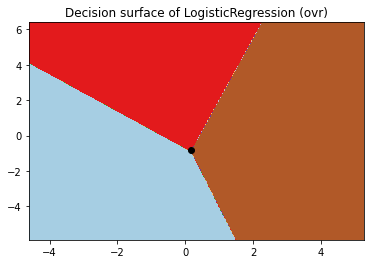

In [548]:
# 실제 중심과 무게중심이 일치하는지 확인
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
plt.axis("tight")

plt.scatter(mean_point[0], mean_point[1], color = 'black')
plt.show()

거의 일치하는 것을 확인할 수 있음<br>
일부 오차가 있을 수 있는 이유는 모델에서 구한 3개의 방정식이 아니라<br>
직접 학습시킨 3개의 직선에 대한 무게중심이기 때문

#### 두 점이 주어졌을 때 직선의 방정식
$(x_1, y_1), (x_2, y_2)$를 잇는 직선의 방정식의 기울기<br>
$\displaystyle m = \frac{y_2 - y_1}{x_2 - x_1} $

In [549]:
# 1번 방정식(mean, A)
get_answer((A[1] - mean_point[1]) / (A[0] - mean_point[0]), A)

'x_2 = -0.98x_1 -0.63'

In [556]:
# 2번 방정식
get_answer((C[1] - mean_point[1]) / (C[0] - mean_point[0]), C)

'x_2 = -3.93x_1 -0.15'

In [557]:
# 3번 방정식
get_answer((B[1] - mean_point[1]) / (B[0] - mean_point[0]), B)

'x_2 = 3.37x_1 -1.34'

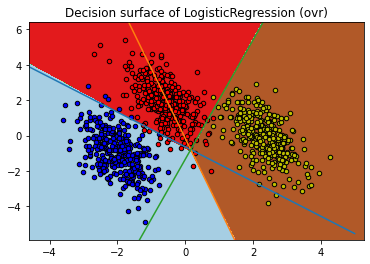

In [558]:
# create a mesh to plot in
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.title("Decision surface of LogisticRegression (ovr)")
plt.axis("tight")

# Plot also the training points
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
    )
    
ans1 = [-0.98 * j - 0.63 for j in x_num]
ans2 = [-3.93 * j - 0.15 for j in x_num]
ans3 = [3.37 * j - 1.34 for j in x_num]

plt.plot(x_num, ans1)
plt.plot(x_num, ans2)
plt.plot(x_num, ans3)
plt.show()

**3개의 직선이 거의 일치하는 것을 확인할 수 있음!!**<br>
<br>
따라서 답은<br>
1번 방정식: $x_2 = -0.98x_1 - 0.63$<br>
2번 방정식: $x_2 = -3.93x_1 - 0.15$<br>
3번 방정식: $x_2 = 3.37x_1 - 1.34$<br>

---
---
---

## Multinomial Logistic Regression

입력 $X$: 1x2 행렬이 데이터 개수 N개 만큼<br>
가중치 $W$(2개의 변수에 대한 가중치, 3개의 클래스): 3x2 행렬<br>
절편 $b$(각각의 행에 1개의 절편, 3개의 클래스): 3x1 행렬<br>
softmax를 거친 행렬 $A$(각각의 행에 1개의 값, 3개의 클래스): 3x1 행렬<br>
<br>
따라서 다음과 같이 표현 가능<br>
$\boldsymbol{Z = WX + b}$<br>
$\boldsymbol{A} = \mbox{softmax}(\boldsymbol{WX + b})$<br>
<br>
레이블 $Y$(3개의 클래스): 3x1 행렬이 데이터 개수 N개 만큼(one-hot 벡터로 표현)<br>
<br>
<br>

### 손실함수

크로스 엔트로피(cross entrophy) 적용<br>
$ E = -\left\{y_0\log(a_0) + y_1\log(a_1) + y_2\log(a_2)\right\}$<br>
<br>
<br>
#### 손실함수의 그레디언트
$\displaystyle\frac{\partial E}{\partial w_{1}}$ 과 $\displaystyle \frac{\partial E}{\partial b_1}$을 구하는 것이 목적(구한 후 일반화)<br>
<br>

$\displaystyle\frac{\partial E}{\partial z_{1}}=\frac{\partial E}{\partial a_{1}} \frac{\partial a_{1}}{\partial z_{1}}+\frac{\partial E}{\partial a_{2}} \frac{\partial a_{2}}{\partial z_{1}}+\frac{\partial E}{\partial a_{3}} \frac{\partial a_{3}}{\partial z_{1}}=\left(-\frac{y_{1}}{a_{1}}\right) \frac{\partial a_{1}}{\partial z_{1}}+\left(-\frac{y_{2}}{a_{2}}\right) \frac{\partial a_{2}}{\partial z_{1}}+\left(-\frac{y_{3}}{a_{3}}\right) \frac{\partial a_{3}}{\partial z_{1}}$<br>


$\displaystyle \begin{aligned} \frac{\partial a_{1}}{\partial z_{1}} &=\frac{\partial}{\partial z_{1}}\left(\frac{e^{z_{1}}}{e^{z_{1}}+e^{z_{2}}+e^{z_{3}}}\right) \\
 &=\frac{e^{z_{1}}\left(e^{z_{1}}+e^{z_{2}}+e^{z_{3}}\right)-e^{z_{1}} e^{z_{1}}}{\left(e^{z_{1}}+e^{z_{2}}+e^{z_{3}}\right)^{2}} \\
&=\frac{e^{z_{1}}}{e^{z_{1}}+e^{z_{2}}+e^{z_{3}}}-\left(\frac{e^{z_{1}}}{e^{z_{1}}+e^{z_{2}}+e^{z_{3}}}\right)^{2} \\ &=a_{1}-a_{1}^{2}=a_{1}\left(1-a_{1}\right) \end{aligned}$



$\begin{aligned} \frac{\partial a_{2}}{\partial z_{1}}=\frac{\partial}{\partial z_{1}}\left(\frac{e^{z_{2}}}{e^{z_{1}}+e^{z_{2}}+e^{z_{3}}}\right) &=\frac{\left(e^{z_{1}}+e^{z_{2}}+e^{z_{3}}\right) \frac{\partial}{\partial z_{1}} e^{z_{2}}-e^{z_{2}} \frac{\partial}{\partial z_{1}}\left(e^{z_{1}}+e^{z_{2}}+e^{z_{3}}\right)}{\left(e^{z_{1}}+e^{z_{2}}+e^{z_{3}}\right)^{2}} \\ &=\frac{O-e^{z_{2}} e^{z_{1}}}{\left(e^{z_{1}}+e^{z_{2}}+e^{z_{3}}\right)^{2}}=-a_{2} a_{1} \\ \frac{\partial a_{3}}{\partial z_{1}}=\frac{\partial}{\partial z_{1}}\left(\frac{e^{z_{3}}}{e^{z_{1}}+e^{z_{2}}+e^{z_{3}}}\right) &=\frac{\left(e^{z_{1}}+e^{z_{2}}+e^{z_{3}}\right) \frac{\partial}{\partial z_{1}} e^{z_{3}}-e^{z_{3}} \frac{\partial}{\partial z_{1}}\left(e^{z_{1}}+e^{z_{2}}+e^{z_{3}}\right)}{\left(e^{z_{1}}+e^{z_{2}}+e^{z_{3}}\right)^{2}} \\ &=\frac{O-e^{z_{3}} e^{z_{1}}}{\left(e^{z_{1}}+e^{z_{2}}+e^{z_{3}}\right)^{2}}=-a_{3} a_{1} \end{aligned}$


$\begin{aligned} \frac{\partial E}{\partial z_{1}} &=\left(-\frac{y_{1}}{a_{1}}\right) \frac{\partial a_{1}}{\partial z_{1}}+\left(-\frac{y_{2}}{a_{2}}\right) \frac{\partial a_{2}}{\partial z_{1}}+\left(-\frac{y_{3}}{a_{3}}\right) \frac{\partial a_{3}}{\partial z_{1}} \\ &=\left(-\frac{y_{1}}{a_{1}}\right) a_{1}\left(1-a_{1}\right)+\left(-\frac{y_{2}}{a_{2}}\right)\left(-a_{2} a_{1}\right)+\left(-\frac{y_{3}}{a_{3}}\right)\left(-a_{3} a_{1}\right) \\ &=-y_{1}\left(1-a_{1}\right)+y_{2} a_{1}+y_{3} a_{1}=-y_{1}+\left(y_{1}+y_{2}+y_{3}\right) a_{1}=-\left(y_{1}-a_{1}\right) \end{aligned}$


<br>
$\displaystyle\frac{\partial E}{\partial w_{1}} = \frac{\partial E}{\partial z_{1}}\frac{\partial z_{1}}{\partial w_{1}} = -\left(y_{1}-a_{1}\right)x_1$<br>
<br>
$\displaystyle \frac{\partial E}{\partial b_1} = \frac{\partial E}{\partial z_{1}}\frac{\partial z_{1}}{\partial w_{1}} = -\left(y_{1}-a_{1}\right)$<br>
<br>
따라서 모든 행에 대해서 적용시킬 수 있도록 일반화 시켜주면<br>
$\displaystyle\frac{\partial E}{\partial \boldsymbol{W}}=-(\boldsymbol{Y}-\boldsymbol{A})\boldsymbol{X}$<br>
<br>
$\displaystyle\frac{\partial E}{\partial \boldsymbol{b}}=-(\boldsymbol{Y}-\boldsymbol{A})$

In [265]:
# 소프트 맥스함수 구현
def softmax(z):
    z = np.clip(z, -100, 100)
    exp_z = np.exp(z)
    return (exp_z / np.sum(exp_z))

In [449]:
from copy import deepcopy

def get_equation_in_multinomial():
    # 타깃에 대해 one-hot encoding
    y_test = np.zeros((y.shape[0], 3))
    
    y_test[np.arange(y.shape[0]), y] = 1
    
    w = np.ones((y_test.shape[1], X.shape[1]))
    b = np.ones(y_test.shape[1])
    
    # 학습률
    lr = 0.02
    loss_history = []

    # epoch는 1000
    for _ in range(1000):
        loss = 0
        for x_i, y_i in zip(X, y_test):
            # z = wX + b
            y_i = y_i.reshape(-1, 1)
            z = w @ x_i + b
            a = softmax(z).reshape(-1, 1)
            # -(y - a)
            loss_grad_common = -(y_i - a)

            # 가중치, 절편의 그레디언트
            # w_grad = -(y - a)x
            # b_grad = -(y - a)
            w_grad = (loss_grad_common * x_i)
            b_grad = loss_grad_common
            
            w -= w_grad * lr
            b -= b_grad.ravel() * lr
            
            loss += -((np.dot(y_i.ravel(), np.log(a).ravel())))
        loss_history.append(loss / len(y))
        
    return w, b, loss_history

In [450]:
w, b, loss_history = get_equation_in_multinomial()

In [451]:
w, b

(array([[-10.44873954,  -2.45627775],
        [  0.04361096,   2.31567236],
        [ 13.40512858,   3.14060538]]),
 array([-2.63103132,  8.61749026, -2.98645894]))

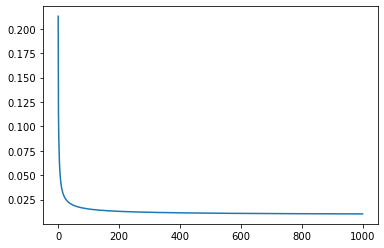

In [452]:
# 오차가 충분히 작은 것을 확인할 수 있음
%matplotlib inline
plt.plot(loss_history)
plt.show()

### 3개의 그래프

In [453]:
h1_m, h1_b = get_equation([w[0, 0], w[0, 1]], b[0])

X[1]에 관해 방정식 정리
기울기: -4.2538917039812105
절편: -1.071145686401256
X[1] = -4.25X[0] -1.07


In [454]:
h2_m, h2_b = get_equation([w[1, 0], w[1, 1]], b[1])

X[1]에 관해 방정식 정리
기울기: -0.018832958301333816
절편: -3.721377165550541
X[1] = -0.02X[0] -3.72


In [455]:
h3_m, h3_b = get_equation([w[2, 0], w[2, 1]], b[2])

X[1]에 관해 방정식 정리
기울기: -4.2683263054466805
절편: 0.9509182399671141
X[1] = -4.27X[0] +0.95


### 3개의 방정식
클래스 0과 1을 구분하는 소프트맥스 함수 값의 분자는<br>
$\displaystyle\frac{e^{z_{0}}}{e^{z_{0}}+e^{z_{1}}+e^{z_{2}}}$과 $\displaystyle\frac{e^{z_{0}}}{e^{z_{0}}+e^{z_{1}}+e^{z_{2}}}$에서 에서<br>
<br>
$e^{z_{0}} = e^{z_{1}} \Leftrightarrow z_0 = z_1$을 만족하는 방정식이 클래스 0과 1을 구분하는 결정경계가 된다

In [456]:
# 클래스 0과 1분리
w0_0, w0_1, b_b = get_answer2(w[0, :], b[0], w[1, :], b[1])
m1, b1 = get_equation([w0_0, w0_1], b_b)

X[1]에 관해 방정식 정리
기울기: -2.198755278340899
절편: -2.3572169256099884
X[1] = -2.20X[0] -2.36


In [457]:
# 클래스 1과 2분리
w1_0, w1_1, b_b = get_answer2(w[1, :], b[1], w[2, :], b[2])
m2, b2 = get_equation([w1_0, w1_1], b_b)

X[1]에 관해 방정식 정리
기울기: -16.197093936582508
절편: 14.066535007289316
X[1] = -16.20X[0] +14.07


In [458]:
# 클래스 0과 2분리
w2_0, w2_1, b_b = get_answer2(w[2, :], b[2], w[0, :], b[0])
m3, b3 = get_equation([w2_0, w2_1], b_b)

X[1]에 관해 방정식 정리
기울기: -4.261991459864107
절편: 0.06350456510555005
X[1] = -4.26X[0] +0.06


0과 1를 구분하는 방정식: $x_2 = -2.2x_1 - 2.36$<br>
1과 2를 구분하는 방정식: $x_2 = -16.2x_1 - 14.07$<br>
2와 0을 구분하는 방정식: $x_2 = -4.26x_1 - 0.06$<br>

### 결정 경계의 중심
결정 경계의 중심은 세 개의 softmax함수 값이 같을 때로, $w_{n0}x_{n0} + w_{n1}x_{n1} + b_{n}$ 의 값이 서로 같을 때 이므로<br>
행렬로 표현하면 다음과 같다.<br>
$\boldsymbol{WX = -b}$<br>
그런데 $\boldsymbol{W}$는 3x2행렬로 정방행렬이 아니므로 역행렬을 구할 수 없다.<br>
<br>
따라서 무어-펜로즈 역행렬을 이용하여 해를 구하면 다음과 같다
$\boldsymbol{X = W^+(-b)}$<br>

In [459]:
# 최소 제곱해를 이용하여 중심 구하기
ppp = np.linalg.pinv(w) @ -b
ppp

array([ 0.92158882, -3.74350295])

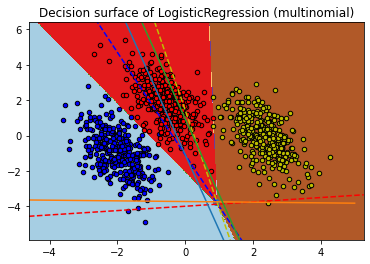

In [460]:
# 중심이 일치하는지 확인

# 추가적으로 z1, z2, z3 그래프 비교
clf = LogisticRegression(
    solver="sag", max_iter=100, random_state=42, multi_class='multinomial'
).fit(X, y)

# create a mesh to plot in
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.title("Decision surface of LogisticRegression (multinomial)")
plt.axis("tight")

# Plot also the training points
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
    )

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_

def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color)

for i, color in zip(clf.classes_, colors):
    plot_hyperplane(i, color)


# 직접 구한 w, b와 coef_, intercept_로 그린 그래프 비교
x = [-5, 5]
    
y1 = [h1_m * x1 + h1_b for x1 in x]
y2 = [h2_m * x1 + h2_b for x1 in x]
y3 = [h3_m * x1 + h3_b for x1 in x]
    
plt.scatter(ppp[0], ppp[1])
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.show()

#### 결정경계 방정식 확인

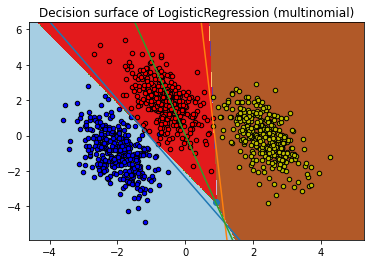

In [461]:
# 각각의 결정경계 방정식을 그리기
x = [-5, 5]
y1 = [m1 * x1 + b1 for x1 in x]
y2 = [m2 * x1 + b2 for x1 in x]
y3 = [m3 * x1 + b3 for x1 in x]

# plt.axis([-10, 5, -10, 5])
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.title("Decision surface of LogisticRegression (multinomial)")
plt.axis("tight")

# Plot also the training points
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
    )
    
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.scatter(ppp[0], ppp[1])


plt.show()

따라서 결정 경계 방정식은 다음과 같다.<br>
1번 방정식: $x_2 = -2.2x_1 - 2.36$<br>
2번 방정식: $x_2 = -4.26x_1 - 0.06$<br>
3번 방정식: $x_2 = -16.2x_1 - 14.07$<br>